In [1]:
!pip install statsmodels==0.14.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 142.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 57.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import statsmodels.api as sm

In [3]:
df = pd.read_csv('UKRetail.csv')

df.shape

(541909, 8)

In [4]:
cat_codes = ['84029G', '84029E','71053','22745','22752']

In [5]:
for i in df.Description[df['StockCode'].isin(cat_codes)].unique():
    print(i)

WHITE METAL LANTERN
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
POPPY'S PLAYHOUSE BEDROOM 
nan
WHITE MOROCCAN METAL LANTERN


In [6]:
df[df['StockCode'].isin(cat_codes)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,12/1/2010 8:34,2.10,13047.0,United Kingdom
...,...,...,...,...,...,...,...,...
541000,581492,22745,POPPY'S PLAYHOUSE BEDROOM,2,12/9/2011 10:03,4.13,NaN,United Kingdom
541320,581497,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,11,12/9/2011 10:23,8.29,NaN,United Kingdom
541511,581498,71053,WHITE MOROCCAN METAL LANTERN,1,12/9/2011 10:26,8.29,NaN,United Kingdom
541520,581498,84029E,RED WOOLLY HOTTIE WHITE HEART.,4,12/9/2011 10:26,8.29,NaN,United Kingdom


In [7]:
#Convert 'InvoiceDate' to datetime format
import datetime as dt

df2 = df.copy()
df2.InvoiceDate = pd.to_datetime(df2.InvoiceDate, format='%m/%d/%Y %H:%M').dt.date

In [8]:
#Get the Top ten Products in the store
top_cats = []

for i,cat in enumerate(list(df2.StockCode.unique())):
    if i <= 10:
        top_cats.append(cat)
    i+=1

top_cats

['85123A',
 '71053',
 '84406B',
 '84029G',
 '84029E',
 '22752',
 '21730',
 '22633',
 '22632',
 '84879',
 '22745']

In [9]:
#Slice df and filter for only the top ten categories
df2 = df2[['InvoiceDate', 'StockCode', 'Quantity', 'UnitPrice']]
df2 = df2[df2['StockCode'].isin(top_cats)]

In [10]:
import numpy as np
results_by_category = {}

#Loop through each category and run a linear regression ont he full set of that particular category
for category, group in df2.groupby("StockCode"):
    try:
        #Remove all records with zero quantity or unit price
        group = group[(group["UnitPrice"] > 0) & (group["Quantity"] > 0)]

        # Log transform
        x = np.log(group["UnitPrice"])
        y = np.log(group["Quantity"])

        # Add constant
        x = sm.add_constant(x)

        # Fit model
        model = sm.OLS(y, x).fit()

        # Store result
        results_by_category[category] = model

        print(f"\nCategory: {category}")
        print(model.summary())
    except Exception as e:
        print(f"Could not model category {category}: {e}")


Category: 21730
                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     31.48
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           1.16e-07
Time:                        22:20:48   Log-Likelihood:                -145.02
No. Observations:                 132   AIC:                             294.0
Df Residuals:                     130   BIC:                             299.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5278      0.452   

In [11]:
#Create a datafram of the elasticities and add statistical values

elasticity_df = pd.DataFrame({
    'Category': cat,
    'Elasticity': round(model.params[1],3),
    'p-value': round(model.pvalues[1],3),
    'R-squared': round(model.rsquared,3)
}
for cat,model in results_by_category.items())

elasticity_df.sort_values('Elasticity', ascending=False)

/tmp/ipykernel_108/2665914414.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Elasticity': round(model.params[1],3),
/tmp/ipykernel_108/2665914414.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p-value': round(model.pvalues[1],3),


,Category,Elasticity,p-value,R-squared
7,84029G,-0.803,0.0,0.067
6,84029E,-0.922,0.0,0.075
5,71053,-0.989,0.0,0.135
3,22745,-1.408,0.0,0.164
4,22752,-1.496,0.0,0.231
0,21730,-1.525,0.0,0.195
9,84879,-1.683,0.0,0.044
8,84406B,-1.768,0.0,0.200
2,22633,-1.987,0.0,0.072
1,22632,-2.571,0.0,0.144


In [12]:
df_bottle = df2[['InvoiceDate', 'StockCode', 'Quantity', 'UnitPrice']].copy()

# Convert 'InvoiceDate' to datetime format
df_bottle['InvoiceDate'] = pd.to_datetime(df_bottle['InvoiceDate'])

# Set 'InvoiceDate' as the index
df_bottle.set_index('InvoiceDate', inplace=True)

# Filter for StockCode '84029G'
df_bottle = df_bottle[df_bottle['StockCode'] == '84029G']

# Drop non-numeric columns before resampling
df_bottle = df_bottle[['Quantity', 'UnitPrice']]

# Sort the index
df_bottle.sort_index(inplace=True)

## Visualize Price and Demand average MoM
This step helps identify opportunities to increase price for inelastic products for seasonal demand and predict stock needs.

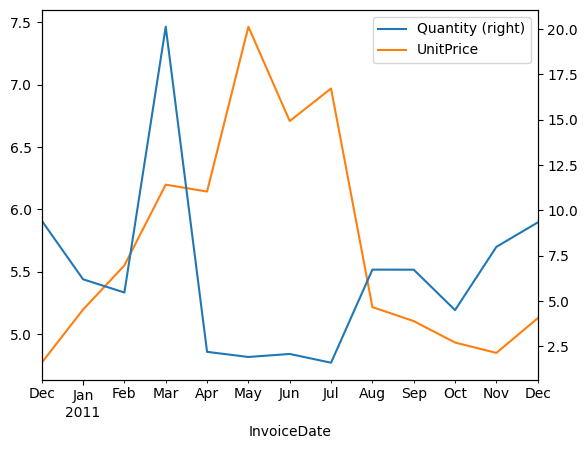

In [13]:
import matplotlib.pyplot as plt

# Resample weekly and calculate the mean
df_resampled = df_bottle.resample('M').mean()

df_resampled.shape

df_resampled.Quantity.plot(secondary_y=True, legend = 1)
df_resampled.UnitPrice.plot(legend = 1)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f738fa55-7339-4125-bf55-c4a398451c3f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>